Benchmarking on spatial DBIT_seq mouse embryo

In [1]:
import pandas as pd
import seaborn as sns
import anndata as ad
import numpy as np
import squidpy as sq
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

def weighted_moran_I(adata,method):
    n_clusters = adata.obs[method].unique()
    total_samples = adata.X.shape[0]

    moran_indices = []
    cluster_sizes = []

    for cluster in n_clusters:
        column_name = f'cluster_{cluster}'
        adata.obs[column_name] = np.where(adata.obs[method] == cluster, 1, 0)
        
  
    sq.gr.spatial_neighbors(adata)

    for cluster in n_clusters:
        column_name = f'cluster_{cluster}'
        
        
        cluster_size = adata.obs[column_name].sum()
        cluster_sizes.append(cluster_size)
        
        
        sq.gr.spatial_autocorr(adata, mode='moran', genes=[column_name], attr='obs')
        moran_index = adata.uns['moranI']['I'][0]
        moran_indices.append(moran_index)

   
    moran_indices = np.array(moran_indices)
    cluster_sizes = np.array(cluster_sizes)

    weighted_moran = np.sum((cluster_sizes / total_samples) * moran_indices)

    return weighted_moran

def _compute_CHAOS(clusterlabel, location):

        clusterlabel = np.array(clusterlabel)
        location = np.array(location)
        matched_location = StandardScaler().fit_transform(location)

        clusterlabel_unique = np.unique(clusterlabel)
        dist_val = np.zeros(len(clusterlabel_unique))
        count = 0
        for k in clusterlabel_unique:
            location_cluster = matched_location[clusterlabel==k,:]
            if len(location_cluster)<=2:
                continue
            n_location_cluster = len(location_cluster)
            results = [fx_1NN(i,location_cluster) for i in range(n_location_cluster)]
            dist_val[count] = np.sum(results)
            count = count + 1

        return np.sum(dist_val)/len(clusterlabel)

def fx_1NN(i,location_in):
        location_in = np.array(location_in)
        dist_array = distance_matrix(location_in[i,:][None,:],location_in)[0,:]
        dist_array[i] = np.inf
        return np.min(dist_array)
    

def fx_kNN(i,location_in,k,cluster_in):

        location_in = np.array(location_in)
        cluster_in = np.array(cluster_in)


        dist_array = distance_matrix(location_in[i,:][None,:],location_in)[0,:]
        dist_array[i] = np.inf
        ind = np.argsort(dist_array)[:k]
        cluster_use = np.array(cluster_in)
        if np.sum(cluster_use[ind]!=cluster_in[i])>(k/2):
            return 1
        else:
            return 0
        
def _compute_PAS(clusterlabel,location):
        
        clusterlabel = np.array(clusterlabel)
        location = np.array(location)
        matched_location = location
        results = [fx_kNN(i,matched_location,k=10,cluster_in=clusterlabel) for i in range(matched_location.shape[0])]
        return np.sum(results)/len(clusterlabel)

def compute_CHAOS(adata,pred_key,spatial_key='spatial'):
        return _compute_CHAOS(adata.obs[pred_key],adata.obsm[spatial_key])

def compute_PAS(adata,pred_key,spatial_key='spatial'):
        return _compute_PAS(adata.obs[pred_key],adata.obsm[spatial_key])

def compute_ASW(adata,pred_key,spatial_key='spatial'):
        d = squareform(pdist(adata.obsm[spatial_key]))
        score_rescaled = (silhouette_score(X=d,labels=adata.obs[pred_key],metric='precomputed') + 1) / 2
        return score_rescaled


In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

def calculate_as(df):
    df['RANK_CHAOS'] = df['CHAOS'].rank(ascending=False)
    df['RANK_PAS'] = df['PAS'].rank(ascending=False)
    df['RANK_ASW'] = df['ASW'].rank(ascending=True)
    df['RANK_Moran'] = df['Moran'].rank(ascending=True)

    df['Overall Score'] = df[['RANK_CHAOS', 'RANK_PAS', 'RANK_ASW', 'RANK_Moran']].mean(axis=1)

    df = df.drop('RANK_CHAOS', axis=1)
    df = df.drop('RANK_PAS', axis=1)
    df = df.drop('RANK_ASW', axis=1)
    df = df.drop('RANK_Moran', axis=1)
    
    return df


sc.settings.set_figure_params(dpi_save=300, dpi=120, fontsize=10, transparent=True, figsize =(3,2.5), format='pdf')
adata=ad.read_h5ad('data\spatial DBIT_seq mouse embryo\mouse_embro_0713_rna.h5ad')
adata.var_names_make_unique()

methods = ['Seurat','totalVI','STAGATE','GraphST','SpatialGlue','PRESENT','MISO','MultiSP']  
results=[]
for method in methods:
     if method=='PRESENT':
                df_cluster=pd.read_csv(f'data/spatial DBIT_seq mouse embryo/baseline_results/{method}/mouse_embryo_0713_{method}_clusters.csv', index_col=0)
                index = df_cluster.index.tolist()
                new_adata = adata[adata.obs_names.isin(index)].copy()
                new_adata.obs[f"{method}"] = df_cluster

                chaos_score =compute_CHAOS(new_adata, f"{method}")
                pas_score = compute_PAS(new_adata, f"{method}")
                asw_score = compute_ASW(new_adata, f"{method}")
                moran_score = weighted_moran_I(new_adata, method=f"{method}")

     else:
                adata.obs[f"{method}"] = pd.read_csv(f'data/spatial DBIT_seq mouse embryo/baseline_results/{method}/mouse_embryo_0713_{method}_clusters.csv', index_col=0)

                chaos_score =compute_CHAOS(adata, f"{method}")
                pas_score = compute_PAS(adata, f"{method}")
                asw_score = compute_ASW(adata, f"{method}")
                moran_score = weighted_moran_I(adata, method=f"{method}")


     results.append({
        'CHAOS':chaos_score,
        'PAS':pas_score,
        'ASW':asw_score,
        'Moran':moran_score,
                }) 

df=pd.DataFrame(results)
df.index = [f'{method}' for method in methods]

df=calculate_as(df)



C:\Users\mcf\AppData\Local\Temp\ipykernel_27992\3222552284.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  moran_index = adata.uns['moranI']['I'][0]
C:\Users\mcf\AppData\Local\Temp\ipykernel_27992\3222552284.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  moran_index = adata.uns['moranI']['I'][0]
C:\Users\mcf\AppData\Local\Temp\ipykernel_27992\3222552284.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  moran_index = ad

Performance of different methods on four metrics

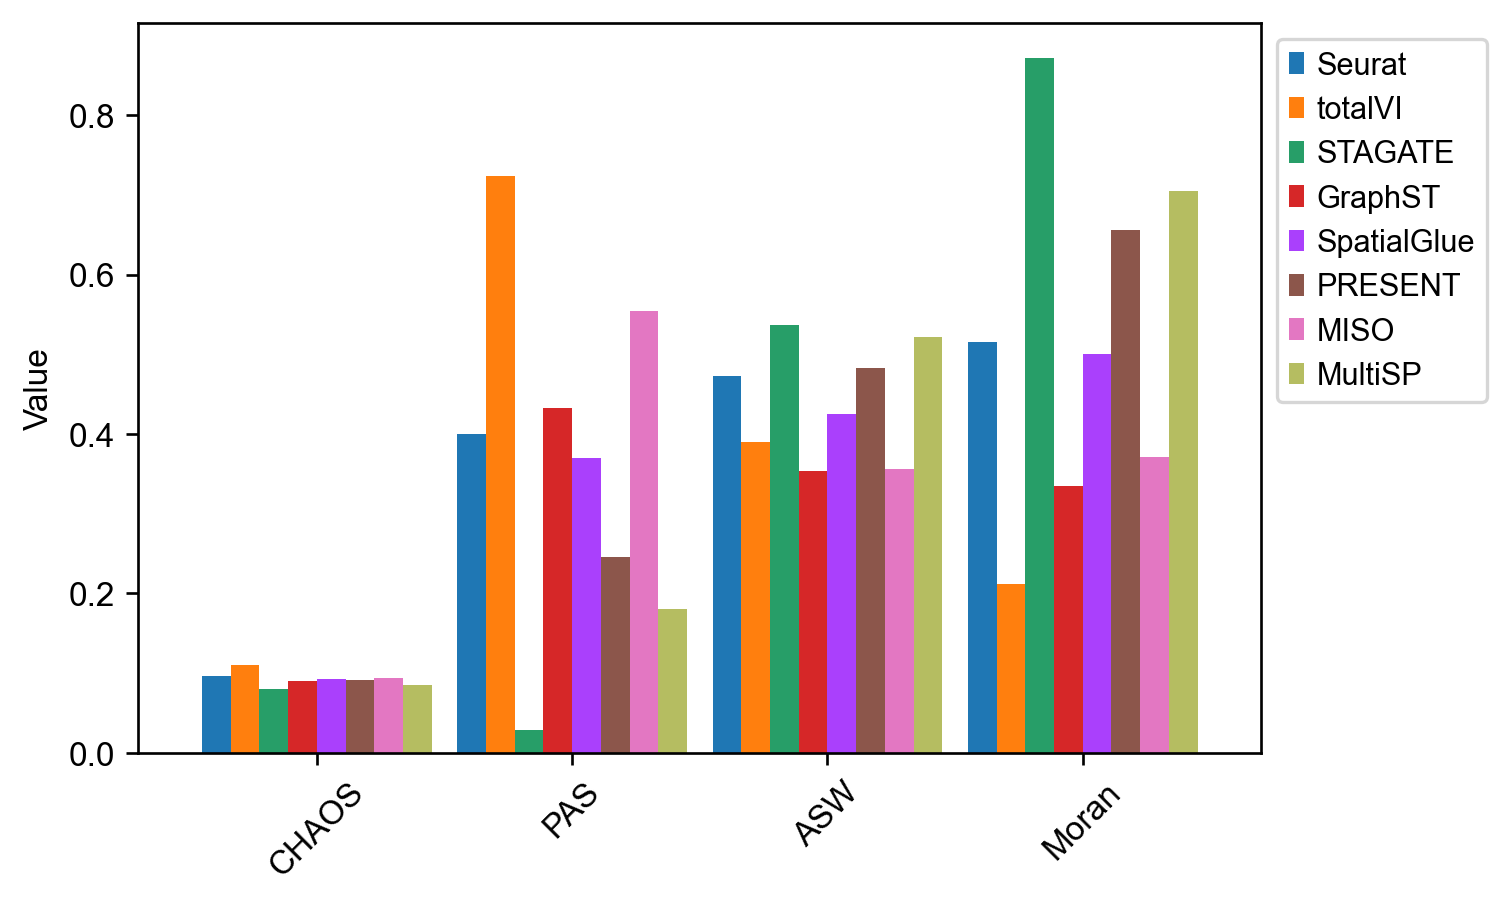

In [3]:
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.family'] = 'Arial'

df[['CHAOS', 'PAS', 'ASW','Moran']].T.plot(kind='bar', width=0.9)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.ylabel('Value')

plt.grid(False) 


Performance of different methods on overall score

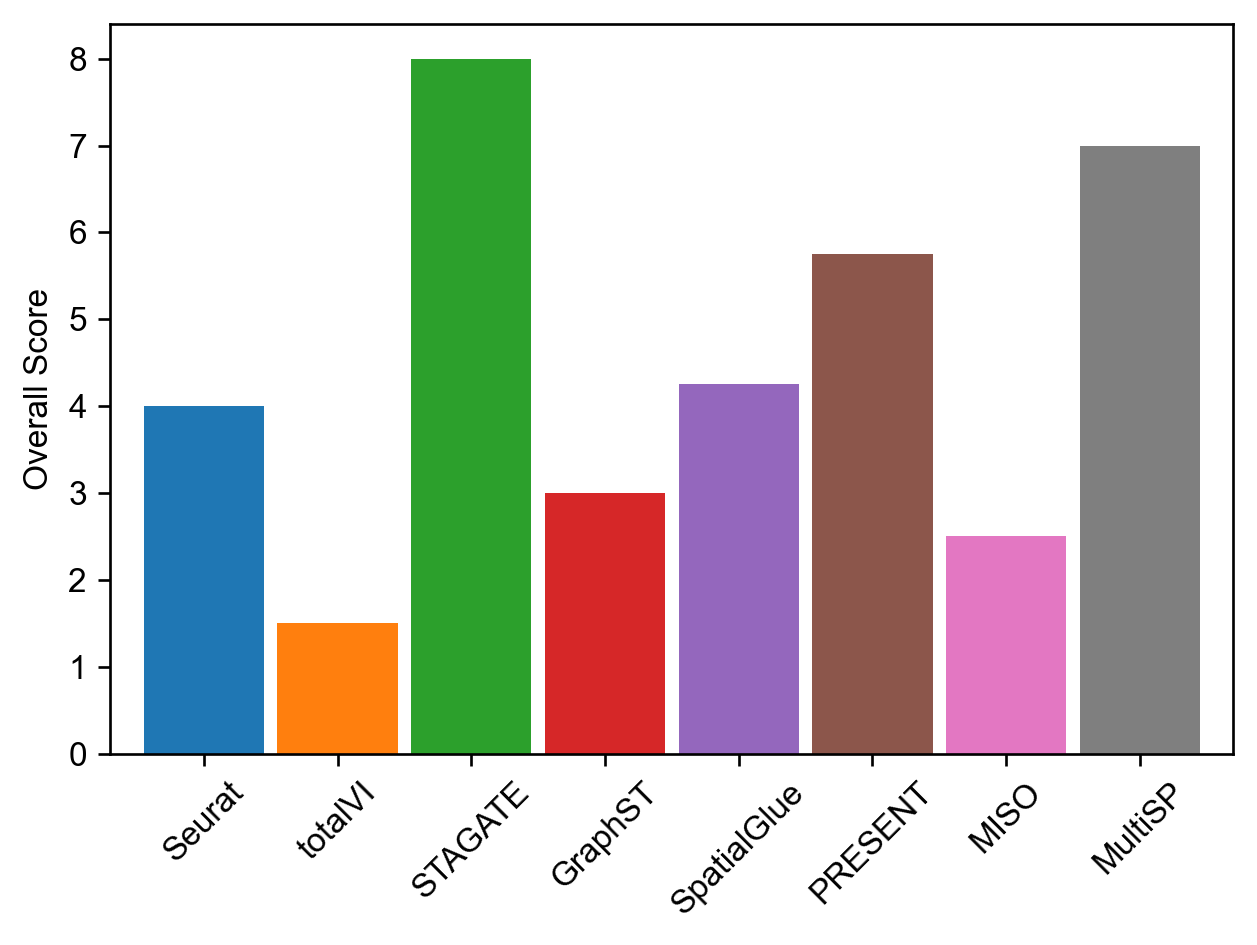

In [4]:
import matplotlib.pyplot as plt

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['font.family'] = 'Arial'

df['Overall Score'].T.plot(kind='bar', width=0.9,color=colors)
plt.xticks(rotation=45)
plt.ylabel('Overall Score')

plt.grid(False) 


Spatial domains identified by different methods

d:\anaconda\envs\pytorch\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
d:\anaconda\envs\pytorch\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\anaconda\envs\pytorch\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
d:\anaconda\envs\pytorch\Lib\site-packages\sca

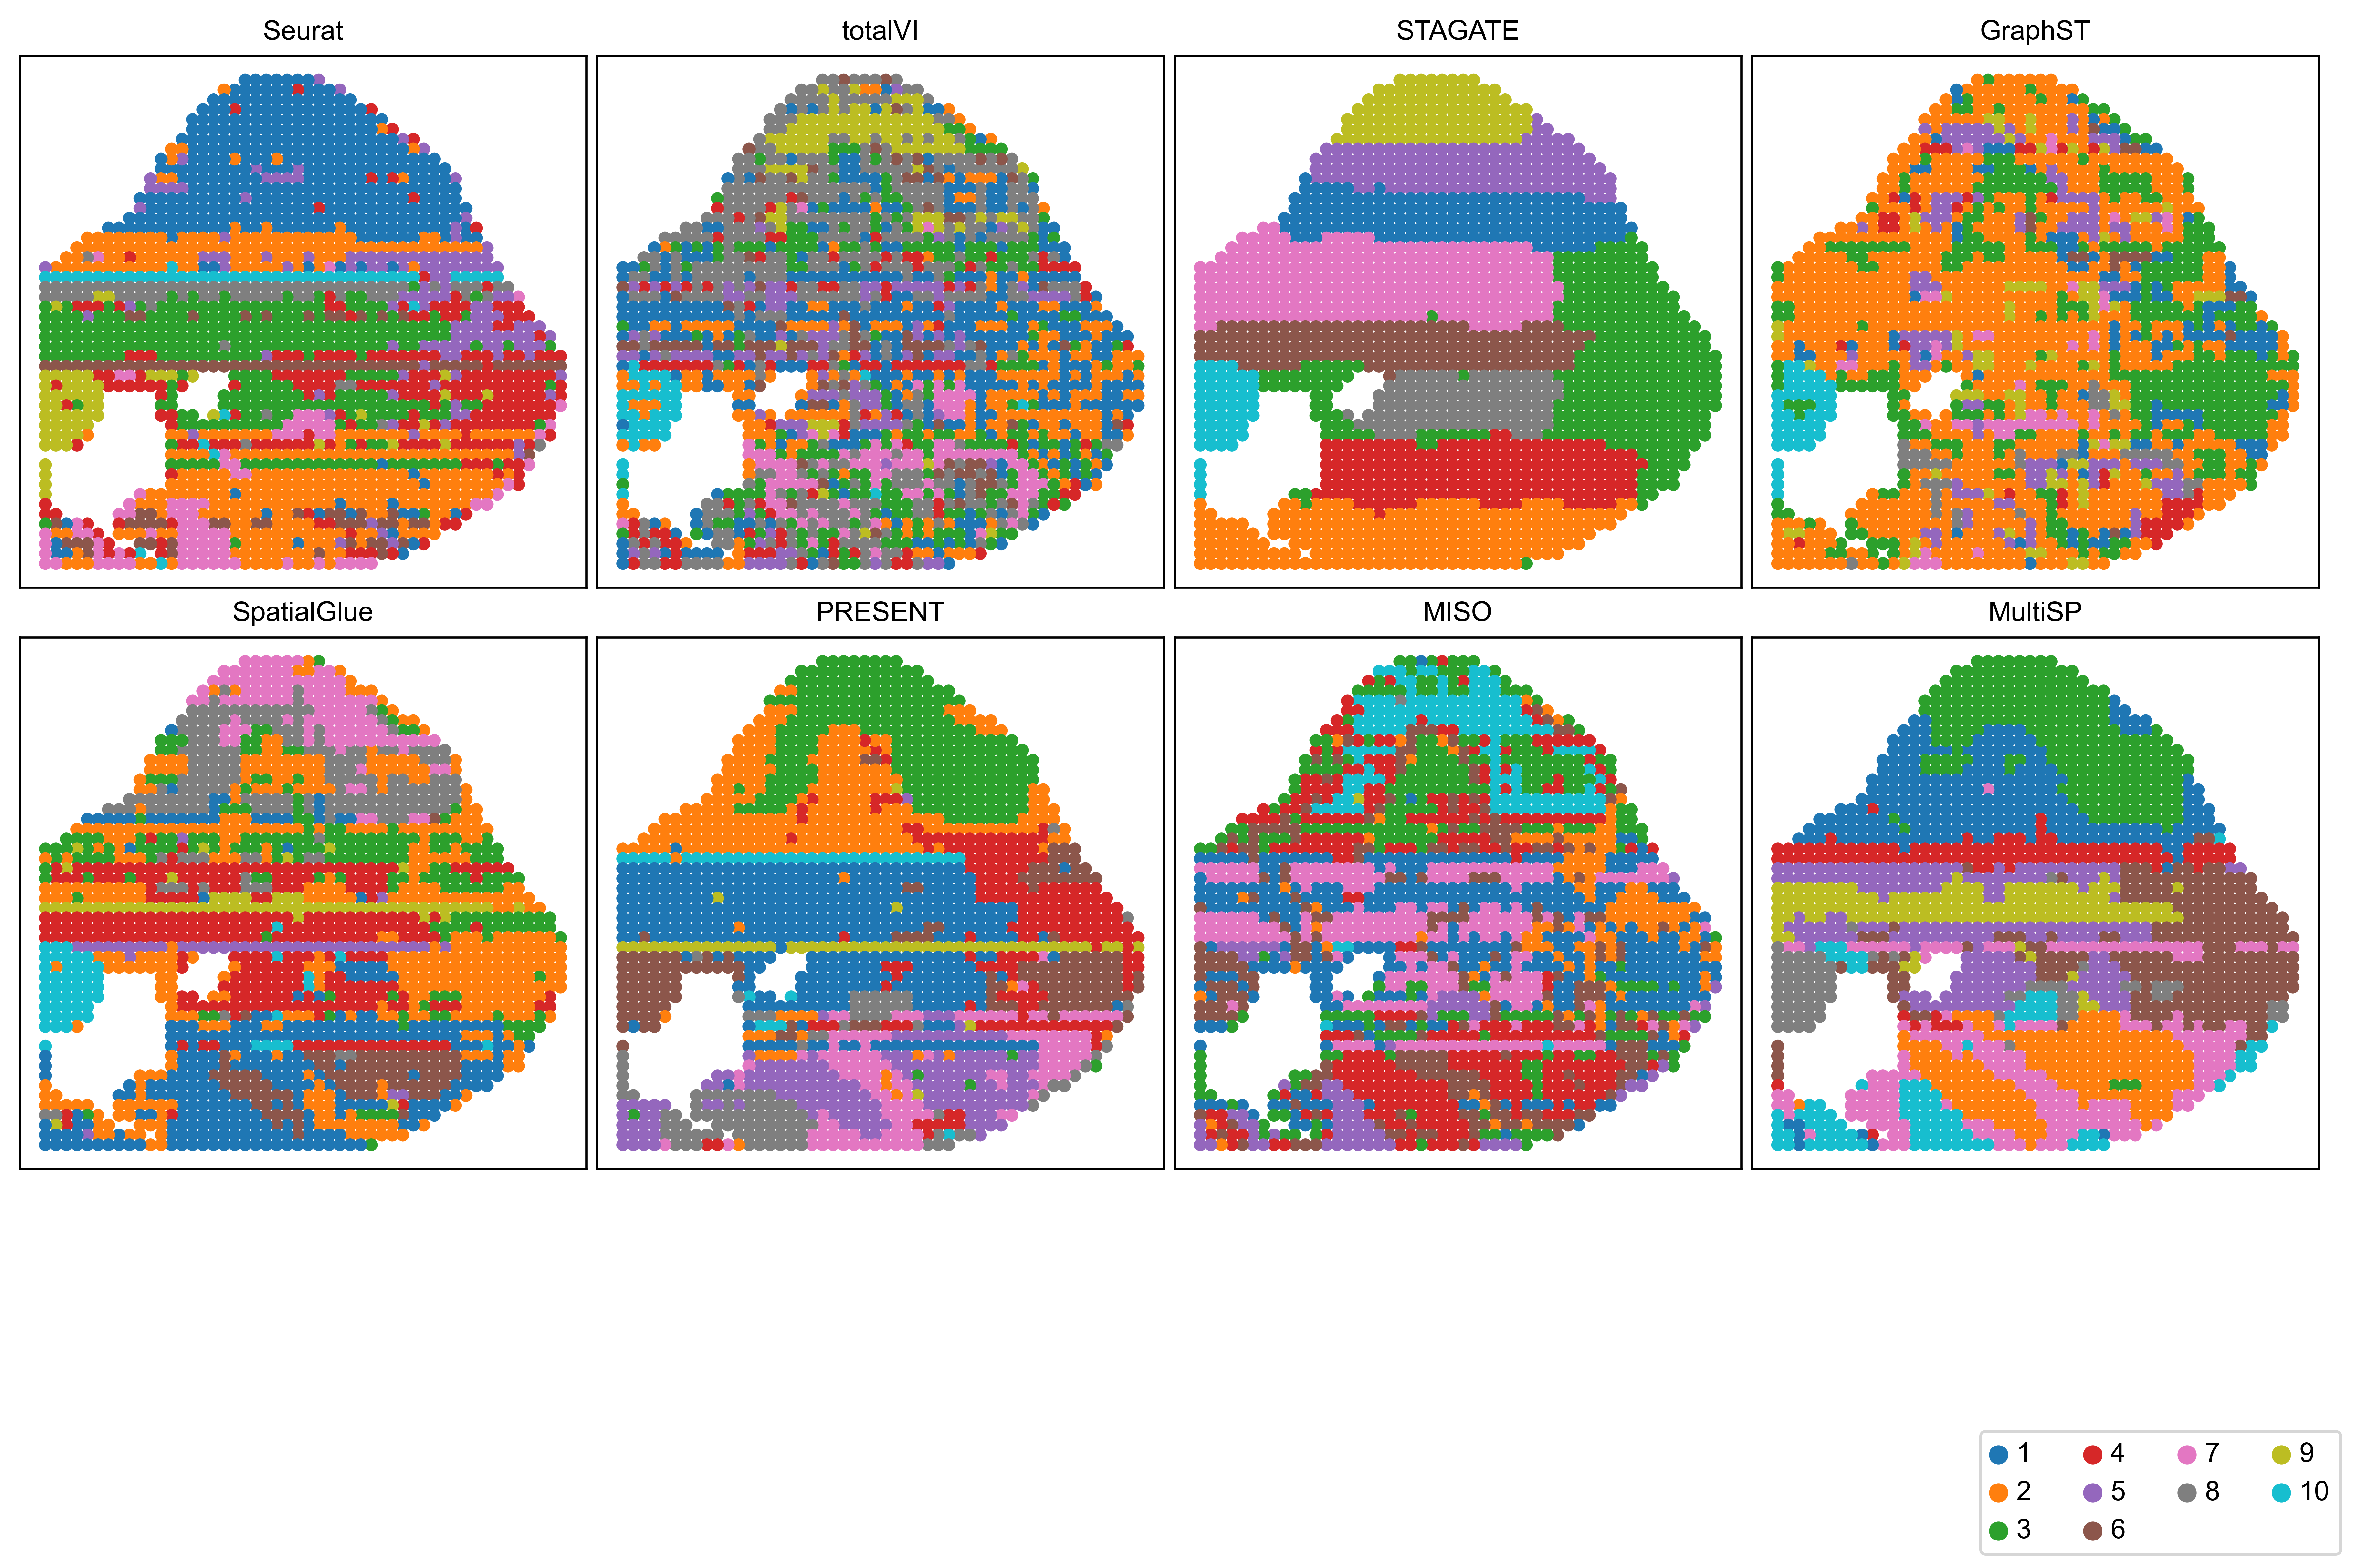

In [5]:
import anndata as ad
import pandas as pd
import scanpy as sc
methods = ['Seurat','totalVI','STAGATE','GraphST','SpatialGlue','PRESENT','MISO','MultiSP']  

for method in methods:
    adata.obs[method]=pd.read_csv(f'data/spatial DBIT_seq mouse embryo/baseline_results/{method}/mouse_embryo_0713_{method}_clusters.csv', index_col=0)
    adata.obs[method]=adata.obs[method].astype(str)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'
sc.settings.set_figure_params(dpi_save=300, dpi=300, fontsize=10, transparent=True, figsize =(3,2.5), format='pdf')
fig, ax_list = plt.subplots(2,4, figsize=(12,8)) 
s_size = 90
sc_colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sc.settings.set_figure_params(dpi_save=300, dpi=300, fontsize=10, transparent=True, figsize =(3,2.5), format='pdf')

for idx, method in enumerate(methods):
    row, col = divmod(idx, 4)
    sc.pl.embedding(adata, basis='spatial', color=method, ax=ax_list[row, col], s=s_size, show=False, palette=sc_colors)
    ax_list[row, col].invert_yaxis()
    
    ax_list[row, col].get_legend().remove()
    ax_list[row, col].set_xlabel('')
    ax_list[row, col].set_ylabel('')

plt.tight_layout(w_pad=0.4)


handles_multisp, labels_multisp = ax_list[1, 3].get_legend_handles_labels()

fig.legend(handles_multisp, labels_multisp, loc='lower right', ncol=4, fontsize=10)
plt.subplots_adjust(bottom=0.25)
